# Empirical Relationships
_Bryan Graham_    
_University of California at Berkeley_    
_January 2015_ (updated January 2025)    
<br>
#### Code citation:
<br>
Graham, Bryan S. (2019). "Empirical Relationships Python Jupyter Notebook," (Version 1.0) (Computer program). Available at http://bryangraham.github.io/econometrics/ (Accessed 27 May 2019)    

The purpose of this Juypter notebook, and the others which follow, is to concretely illustrate the application of some of the ideas introduced (more abstractly) in lecture. Python is a high-level general purpose computer programming language. It is freely available, and provides a convenient, and widely used, platform for scientific computing. The Anaconda distribution of Python provides most of the core libraries we will use this semester and is easy to install (https://www.anaconda.com/download). 
<br>
<br>
There are many free resources available for learning Python. One, which may be of special interest to economists, can be found at https://quantecon.org/. A good introduction to data manipulation and organization in Python is provided by Wes McKinney in his book _Python for Data Analysis_.  
<br>
<br>
Those components of course problem sets which involve computation should be completed in Python or R. While I will not formally teach Python or R programming, issues of computation will arise frequently in class. It is your responsibility to acquire additional coding skills independently outside of class. Your are, of course, free to ask for help from one another (as well as from me and the course assistant during scheduled office hours). I am mindful that students generally have a wide range of prior experiences with technical computing and programming. I ask that those of you with relatively strong backgrounds in these areas assist classmates who are less familiar with programming. I do not expect any of this to be easy, but we can make it fun if we collaborate.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from warnings import simplefilter
simplefilter(action="ignore", category=UserWarning)

## Loading data
All the calculations in this notebook utilize the _nlsy97ss.csv_ file which is available on the course webpage. This file includes variables extracted from multiple waves of the National Longitudinal Survey of Youth (1997). We will load this file into Python as a pandas dataframe. A good introduction to pandas is provided by the book _Python for Data Analysis_.
<br>
<br>
We will call our dataframe 'nlsy97' and use a hierarchical index structure. Rows are indexed by househould id (hhid97) first, and then within households, by person id (pid97).

In [4]:
# Directory where NLSY79_TeachingExtract.csv file is located
data = '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Data/'
graphics = '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Graphics/'

In [5]:
# Read in NLSY97 Extract
nlsy97 = pd.read_csv(data+'nlsy97ss.csv') # Reading .csv as DataFrame

# Hierarchical index: household, then individual; keep indices as columns too
nlsy97.set_index(['hhid97','pid97'], drop=False, inplace=True)

# Display the first few rows of the dataframe
nlsy97.head()

hhid97  pid97    swgt  cs_smpl  avg_earn_2016_to_2020  \
hhid97 pid97                                                          
2      2           2      2  272178        1          140764.964069   
3      3           3      3  169357        1           34487.266323   
4      4           4      4  149099        1           45864.738658   
8      6           8      6  218371        1           23202.102210   
       7           8      7  232055        1               0.000000   

              hgc_at_age28   asvab  female  black  hispanic birth_month  \
hhid97 pid97                                                              
2      2              14.0  58.483       0      0         1        July   
3      3              14.0  27.978       1      0         1   September   
4      4              13.0  37.012       1      0         1    February   
8      6              14.0  22.001       1      0         1     January   
       7              12.0   3.585       0      0         1       April   

              birth_year  
hhid97 pid97              
2      2            1982  
3      3            1983  
4      4            1981  
8      6            1982  
       7            1983

Our target sample will consist of all male, non-Black, non-Hispanic NLSY respondents in the "core" sample. There are a total of 1,664 respondents in our target sample.

In [6]:
# Only retain non-black, non-hispanic, male NLSY97 respondents belonging to core sample
nlsy97 = nlsy97[(nlsy97.cs_smpl != 0) & (nlsy97.female != 1) & (nlsy97.black == 0) & (nlsy97.hispanic == 0)]

# Basic summary statistics of nlsy97 dataframe
nlsy97.describe()

,hhid97,pid97,swgt,cs_smpl,avg_earn_2016_to_2020,hgc_at_age28,asvab,female,black,hispanic,birth_year
count,1664.000000,1664.000000,1664.000000,1664.0,1664.000000,1664.000000,1664.000000,1664.0,1664.0,1664.0,1664.000000
mean,2998.543269,3559.489784,288281.985577,1.0,80234.840040,13.728966,56.137077,0.0,0.0,0.0,1982.108774
std,1638.090963,1970.671485,25613.040204,0.0,68739.885742,2.816791,28.573988,0.0,0.0,0.0,1.395662
min,30.000000,31.000000,228435.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1980.000000
25%,1763.750000,2071.750000,271894.000000,1.0,38667.161930,12.000000,33.019750,0.0,0.0,0.0,1981.000000
50%,2815.000000,3345.000000,285083.500000,1.0,65619.517507,14.000000,58.603500,0.0,0.0,0.0,1982.000000
75%,4274.500000,5089.250000,301549.250000,1.0,99762.161381,16.000000,81.044000,0.0,0.0,0.0,1983.000000
max,7473.000000,9021.000000,535706.000000,1.0,430919.831933,20.000000,100.000000,0.0,0.0,0.0,1984.000000


In what follows we will explore the relationship between schooling and earnings as an adult. Our earnings variable will be the average of total annual earnings across the 2016, 2018, and 2020 calendar years. If earnings are missing for one of those years, the average will be over all non-missing years. NLSY97 respondents were born in the years 1980 to 1984 and hence were between the ages of 34 and 38 in 2018. Current earnings tend to be relatively close to permanent earnings at age 40, which motivates the selection of these calendar years (which are also the latest available for this NLSY cohort). Earnings are measured in 2022 prices using the CPI-U price index.

In [7]:
# Rename earnings measure
nlsy97.rename(columns={'avg_earn_2016_to_2020': "earnings"}, inplace=True)

# Only retain complete cases of year of birth, earnings, schooling, AFQT and parental education
nlsy97 = nlsy97[["hhid97","pid97","birth_year","earnings","hgc_at_age28","asvab"]] 
nlsy97 = nlsy97.dropna()

# Summary statistics
nlsy97.describe()

,hhid97,pid97,birth_year,earnings,hgc_at_age28,asvab
count,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000
mean,2998.543269,3559.489784,1982.108774,80234.840040,13.728966,56.137077
std,1638.090963,1970.671485,1.395662,68739.885742,2.816791,28.573988
min,30.000000,31.000000,1980.000000,0.000000,0.000000,0.000000
25%,1763.750000,2071.750000,1981.000000,38667.161930,12.000000,33.019750
50%,2815.000000,3345.000000,1982.000000,65619.517507,14.000000,58.603500
75%,4274.500000,5089.250000,1983.000000,99762.161381,16.000000,81.044000
max,7473.000000,9021.000000,1984.000000,430919.831933,20.000000,100.000000


Earnings is a continuously-valued variable (or practically so). For what follows it will be convenient to discretize earnings. The following snippet of code creates earnings buckets, in $\$5,000$ increments from $\$0$ to $\$100,000$, in $\$10,000$ increments from $\$100,000$ to $\$150,000$, and in $\$50,000$ increments from $\$150,000$ to $\$350,000$. All individuals with average earnings exceeding \$350,000 are lumped into a single bucket.
<br>
<br>
Schooling _is_ discretely-valued, measured in whole years of completed schooling. However, in order to avoid complications due to sparse and/or empty cells, we will lump all individuals with less than $12$ years of schooling (i.e., high school dropouts and less) into a single group.
<br>
<br>
After discretizing schooling and earnings we can compute the joint frequency distribution of schooling and earnings.

In [8]:
# Years-of-Schooling buckets
sch_bkts  = [0, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

# Annual earnings buckets
# NOTE: Buckets defined as monotonically decreasing so that the top row of the schooling/earnings
#       cross-tabulation corresponds to the highest income bracket
earn_bkts = [2500000, 350000, 300000, 250000, 200000, 150000, \
             140000, 130000, 120000, 110000, 100000, 95000, 90000, 85000, 80000, \
             75000, 70000, 65000, 60000, 55000, 50000, \
             45000, 40000, 35000, 30000, 25000, 20000, 15000, 10000, 5000, 0]

# Table of counts for each schooling-by-earnings cell with both row and column totals included
# NOTE: np.digitize() returns bin indices with upper bin edges excluded
earn_by_sch = pd.crosstab(np.digitize(nlsy97.earnings, earn_bkts), np.digitize(nlsy97.hgc_at_age28, sch_bkts), \
                          rownames=['Earnings'], colnames=['Schooling'], margins=True)

# Create informative labels for bins and attach them to the cross tabulation 
sch_bin_labels = ['[0,12)', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'Pr(Earn=y)']
earn_bin_labels = ['+350K','[300K,350K)','[250K,300K)','[200K,250K)','[150K,200K)',\
                   '[140K,150K)','[130K,140K)','[120K,130K)','[110K,120K)','[100K,110K)',\
                   '[95K,100K)','[90K,95K)','[85K,90K)','[80K,85K)','[75K,80K)','[70K,75K)', \
                   '[65K,70K)','[60K,65K)','[55K,60K)','[50K,55K)','[45K,50K)','[40K,45K)','[35K,40K)','[30K,35K)', \
                   '[25K,30K)','[20K,25K)','[15K,20K)','[10K,15K)','[5K,10K)','[0K,5K)','Pr(Sch=x)']

# Associate bin labels with cross tabulation
earn_by_sch.index = pd.Index(earn_bin_labels, name="Earnings")
earn_by_sch.columns = pd.Index(sch_bin_labels, name="Schooling")

# Print schooling-by-earnings joint frequency distribution (in percentages)
N = len(nlsy97.earnings)                  # Total number of complete cases
print("Joint Frequency Distribution of Schooling and Earnings, NLSY97")
print("")
print(np.round(100*earn_by_sch/N,2))

Joint Frequency Distribution of Schooling and Earnings, NLSY97

Schooling    [0,12)     12    13     14    15     16    17    18    19    20  \
Earnings                                                                       
+350K          0.06   0.00  0.06   0.06  0.00   0.78  0.30  0.06  0.00  0.42   
[300K,350K)    0.06   0.06  0.00   0.00  0.18   0.30  0.00  0.00  0.12  0.06   
[250K,300K)    0.06   0.12  0.06   0.12  0.00   0.24  0.06  0.06  0.00  0.18   
[200K,250K)    0.06   0.36  0.06   0.18  0.18   0.90  0.12  0.18  0.24  0.06   
[150K,200K)    0.24   0.54  0.36   0.18  0.12   1.38  0.66  0.54  0.12  0.18   
[140K,150K)    0.12   0.30  0.30   0.18  0.18   0.78  0.18  0.24  0.12  0.12   
[130K,140K)    0.18   0.18  0.18   0.12  0.00   0.54  0.30  0.30  0.06  0.12   
[120K,130K)    0.24   0.66  0.00   0.24  0.12   1.26  0.30  0.30  0.24  0.00   
[110K,120K)    0.12   0.36  0.06   0.18  0.18   1.02  0.18  0.30  0.06  0.12   
[100K,110K)    0.24   0.96  0.36   0.54  0.30   0.84  0.

In inspecting the cross-tabulation we can see that most of the probability mass is concentrated along the diagonal running from low-schooling/low-earnings to high-schooling/high-earnings. However there is some mass is almost all cells. 
<br>
<br>
Inspecting the marginal distribution of schooling (the bottom row of the table), we can see that there are large masses of probability in the schooling distribution at $12$ and $16$ years (corresponding to high school and college completion respectively). 
<br>
<br>
The marginal distribution of earnings is reported in the right-most column of the table. Less than 3 percent of NLSY97  respondents in our subsample earned more than $\$350,000$ around $2018$. About one half of respondents earned $\$65,000$ or less.
<br>
<br>
A somewhat more evocative way to report the joint frequency distribution is through a heatmap (with histograms depicting the two marginal distributions). The following snippet of code produces such a figure. In makes use of the _seaborn_ library.
<br>
<br>
The code which follows also computes some basic probabilities and expectations. To do this we need to behave "as if" earnings is a discretely-valued random variable. For this purpose I assume that any individual in a given earnings bin earned the midpoint value of the bin. So I treat all individual in the $\$0$ to $\$5,000$ bin as earning $\$2,500$. I assume that all individuals in the $\$350,000$ and above bin earns $\$400,000$ per annum. This number was calibrated by making a Pareto Tail assumption.

/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_27702/1567648174.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  earn_lvls = np.array([round(float((alpha/(alpha-1))*250000) / 50000)*50000, 325000, 275000, 225000, \
/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_27702/1567648174.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('{:.4f}'.format(float(alpha)))
/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_27702/1567648174.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befo


Calibrated Pareto scale parameter
7.6076

Calibrated average of upper earnings bin
400000

Probability of earning less than $50,000
36.5

Probability of earning less than $50,000 and being a high school dropout
8.4

Expected value of earnings
79286.36

Expected value of schooling
13.96


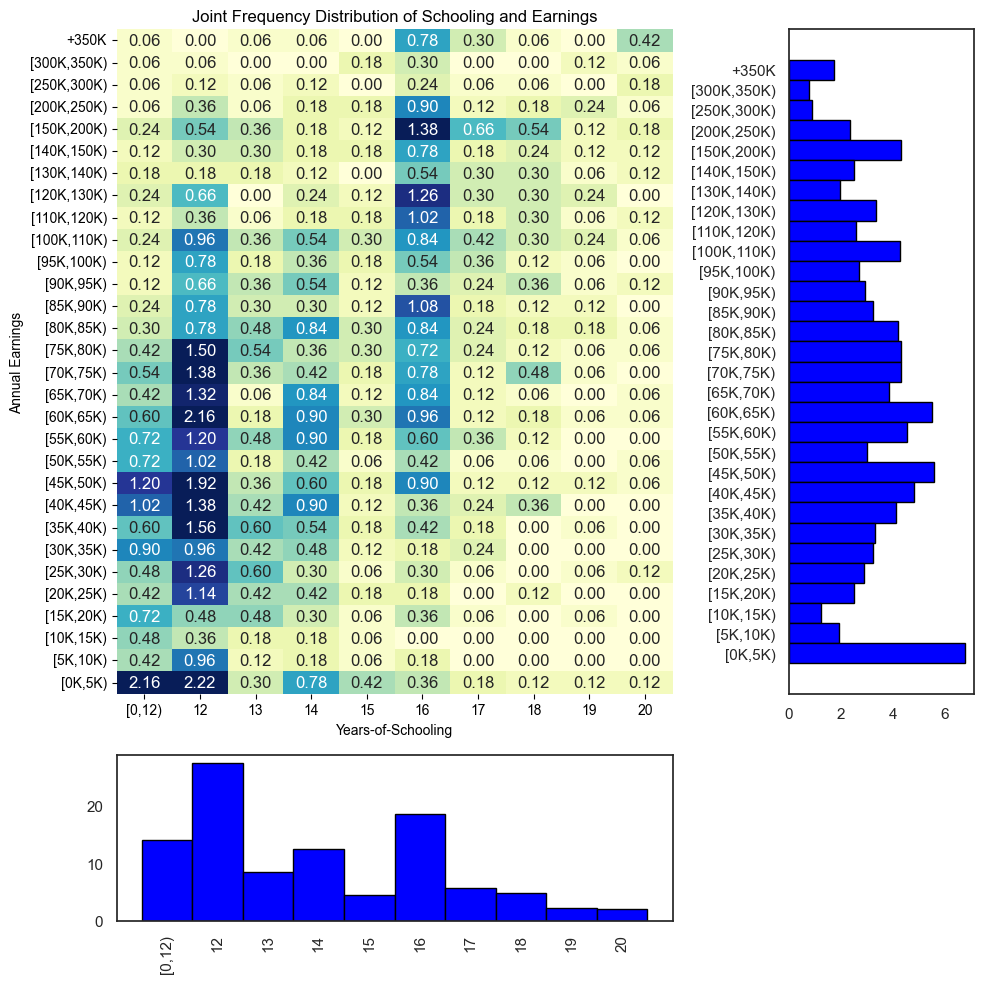

In [9]:
# Convert cross tabulation into a pandas dataframe. 
jfd = pd.DataFrame(100*earn_by_sch/N, index=earn_bin_labels, columns=sch_bin_labels)

# Calculate Pareto shape parameter for upper income bin
shp_num = np.log((np.array(earn_by_sch.loc[['+350K'],['Pr(Earn=y)']]) \
                 + np.array(earn_by_sch.loc[['[300K,350K)'],['Pr(Earn=y)']])) \
                 / np.array(earn_by_sch.loc[['[300K,350K)'],['Pr(Earn=y)']]))
shp_den = np.log(350000/300000)
alpha = shp_num/shp_den

# Attach numeric values to each earnings and schooling bin in order to calculate expectations
earn_lvls = np.array([round(float((alpha/(alpha-1))*250000) / 50000)*50000, 325000, 275000, 225000, \
             175000, 145000, 135000, 125000, 115000, 105000, 97500, 92500, 87500, 82500, 77500, 72500, \
             67500,  62500, 57500, 52500, 47500, 42500, 37500, 32500, 27500, 22500, 17500, 12500, 7500, 2500])
sch_lvls = np.array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

print("")
print("Calibrated Pareto scale parameter")
print('{:.4f}'.format(float(alpha)))
print("")
print("Calibrated average of upper earnings bin")
print(round(float((alpha/(alpha-1))*350000) / 50000)*50000)


# Drop row and columns corresponding to margins
jfd = jfd.drop(labels='Pr(Sch=x)', axis=0)    # Drops schooling margins
jfd = jfd.drop(labels='Pr(Earn=y)', axis=1)   # Drops earnings margins

# Get marginal distributions of earnings and schooling
mfd_earn = jfd.sum(axis=1)
mfd_sch = jfd.sum(axis=0)

# Calculate some probabilities and expectations
print("")
print("Probability of earning less than $50,000")
print('{:.1f}'.format(jfd.loc[['[45K,50K)','[40K,45K)','[35K,40K)','[30K,35K)', \
                               '[25K,30K)','[20K,25K)','[15K,20K)','[10K,15K)','[5K,10K)',\
                               '[0K,5K)']].sum(axis=1).sum(axis=0)))
print("")
print("Probability of earning less than $50,000 and being a high school dropout")
print('{:.1f}'.format(jfd.loc[['[45K,50K)','[40K,45K)','[35K,40K)','[30K,35K)', \
                               '[25K,30K)','[20K,25K)','[15K,20K)','[10K,15K)', \
                               '[5K,10K)','[0K,5K)'],['[0,12)']].sum(axis=1).sum(axis=0)))
print("")
print("Expected value of earnings")
print('{:.2f}'.format(np.sum(mfd_earn/100 * earn_lvls)))
print("")
print("Expected value of schooling")
print('{:.2f}'.format(np.sum(mfd_sch/100 * sch_lvls)))

# Form a plot with a heatmap of the joint frequency distribution at the center and histograms
# of the two marginal frequency distributions on each side.
import matplotlib.gridspec as gridspec

# Create figure; use gridspec to control relative size of three subplots
jfd_fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4,1]) 

# Joint frequency distribion
ax0 = plt.subplot(gs[0])
sns.set(style="white")
sns.heatmap(jfd, cmap="YlGnBu", robust=True, annot=True, fmt=".2f", cbar=False)
plt.title('Joint Frequency Distribution of Schooling and Earnings')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Annual Earnings')

# Marginal frequency distribution of earnings
ax1 = plt.subplot(gs[1])
mfd_earn.plot(kind='barh',width=1, facecolor='blue', edgecolor='black').invert_yaxis()
plt.autoscale()

# Marginal frequency distribution of schooling
ax2 = plt.subplot(gs[2])
mfd_sch.plot(kind='bar',width=1, facecolor='blue', edgecolor='black')
plt.autoscale()

# Save result
plt.tight_layout()
plt.savefig(graphics+'Fig_jfd_earn_by_sch.png')

As discussed in lecture, we are often interested in the conditional distribution of one random variable given another.
To get the conditional frequency distribution of earnings given schooling we divide each element of the joint frequency distribution by its column sum.

Conditional Frequency Distribution of Earnings Given Schooling, NLSY97

             [0,12)    12    13    14    15    16     17     18     19     20
+350K          0.43  0.00  0.71  0.49  0.00  4.23   5.32   1.25   0.00  20.59
[300K,350K)    0.43  0.22  0.00  0.00  3.95  1.63   0.00   0.00   5.41   2.94
[250K,300K)    0.43  0.44  0.71  0.97  0.00  1.30   1.06   1.25   0.00   8.82
[200K,250K)    0.43  1.32  0.71  1.46  3.95  4.89   2.13   3.75  10.81   2.94
[150K,200K)    1.72  1.97  4.26  1.46  2.63  7.49  11.70  11.25   5.41   8.82
[140K,150K)    0.86  1.10  3.55  1.46  3.95  4.23   3.19   5.00   5.41   5.88
[130K,140K)    1.29  0.66  2.13  0.97  0.00  2.93   5.32   6.25   2.70   5.88
[120K,130K)    1.72  2.41  0.00  1.94  2.63  6.84   5.32   6.25  10.81   0.00
[110K,120K)    0.86  1.32  0.71  1.46  3.95  5.54   3.19   6.25   2.70   5.88
[100K,110K)    1.72  3.51  4.26  4.37  6.58  4.56   7.45   6.25  10.81   2.94
[95K,100K)     0.86  2.85  2.13  2.91  3.95  2.93   6.38   2.50   2.70

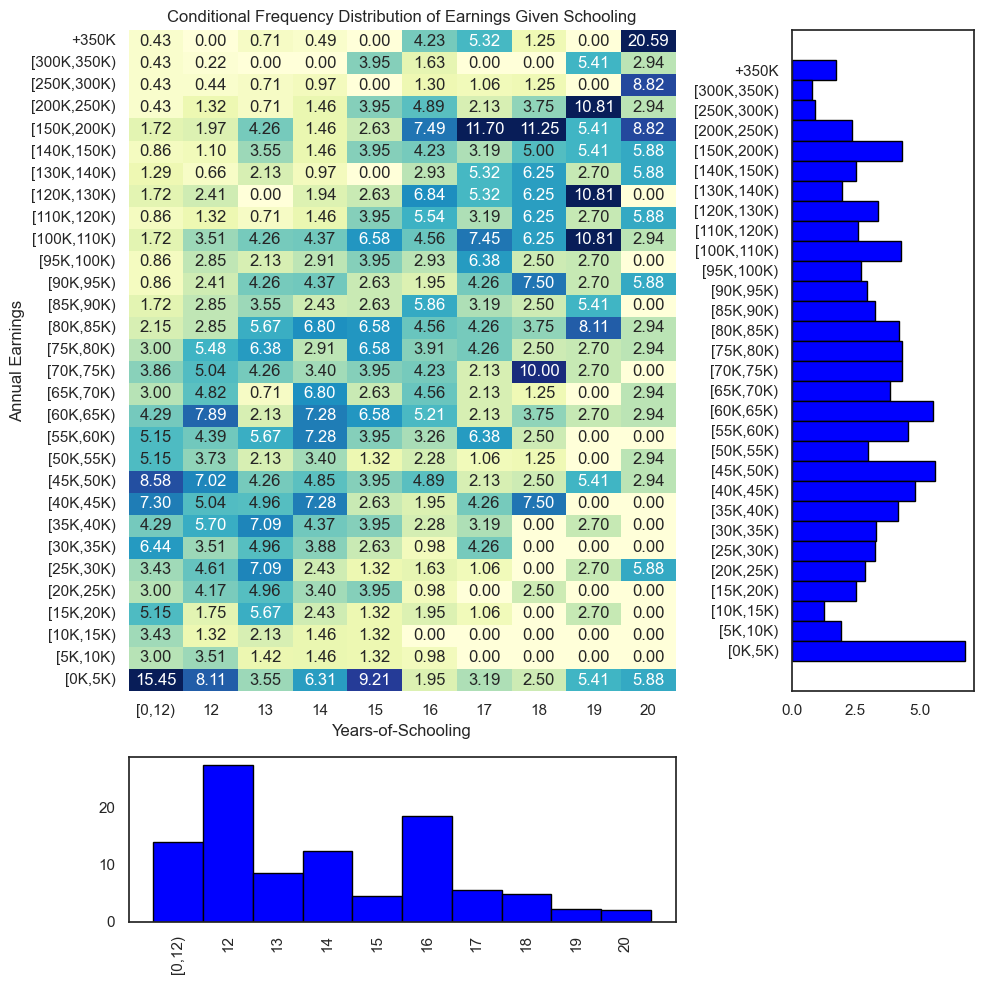

In [10]:
print("Conditional Frequency Distribution of Earnings Given Schooling, NLSY97")
print("")
cfd = (jfd / jfd.sum())*100
print(np.round(cfd,2))

# Form a plot with a heatmap of the conditional frequency distribution at the center and histograms
# of the two marginal frequency distributions on each side.

# Create figure; use gridspec to control relative size of three subplots
cfd_fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[4,1]) 

# Conditional frequency distribion
ax0 = plt.subplot(gs[0])
sns.set(style="white")
sns.heatmap(cfd, cmap="YlGnBu", robust=True, annot=True, fmt=".2f", cbar=False)
plt.title('Conditional Frequency Distribution of Earnings Given Schooling')
plt.xlabel('Years-of-Schooling')
plt.ylabel('Annual Earnings')

# Marginal frequency distribution of earnings
ax1 = plt.subplot(gs[1])
mfd_earn.plot(kind='barh',width=1, facecolor='blue', edgecolor='black').invert_yaxis()
plt.autoscale()

# Marginal frequency distribution of schooling
ax2 = plt.subplot(gs[2])
mfd_sch.plot(kind='bar',width=1, facecolor='blue', edgecolor='black')
plt.autoscale()

# Save result
plt.tight_layout()
plt.savefig(graphics+'Fig_cfd_earn_given_sch.png')

## Conditional mean and median regression
The conditional distribution of earnings given schooling is easier to interpret than the corresponding joint one. For example, we observe that while 25 percent of respondents with 20 years of schooling (essentially corresponding to a Ph.D) earned more that $250,000, only 0.5 percent of high school graduates did. The heatmap also clearly shows that the conditional distribution of earnings "shifts to the right" as schooling increases.
<br>
<br>
To get a single "prototypical" measure of earnings for each schooling level, we can use the pandas groupby function to compute mean and median earnings conditional on schooling.

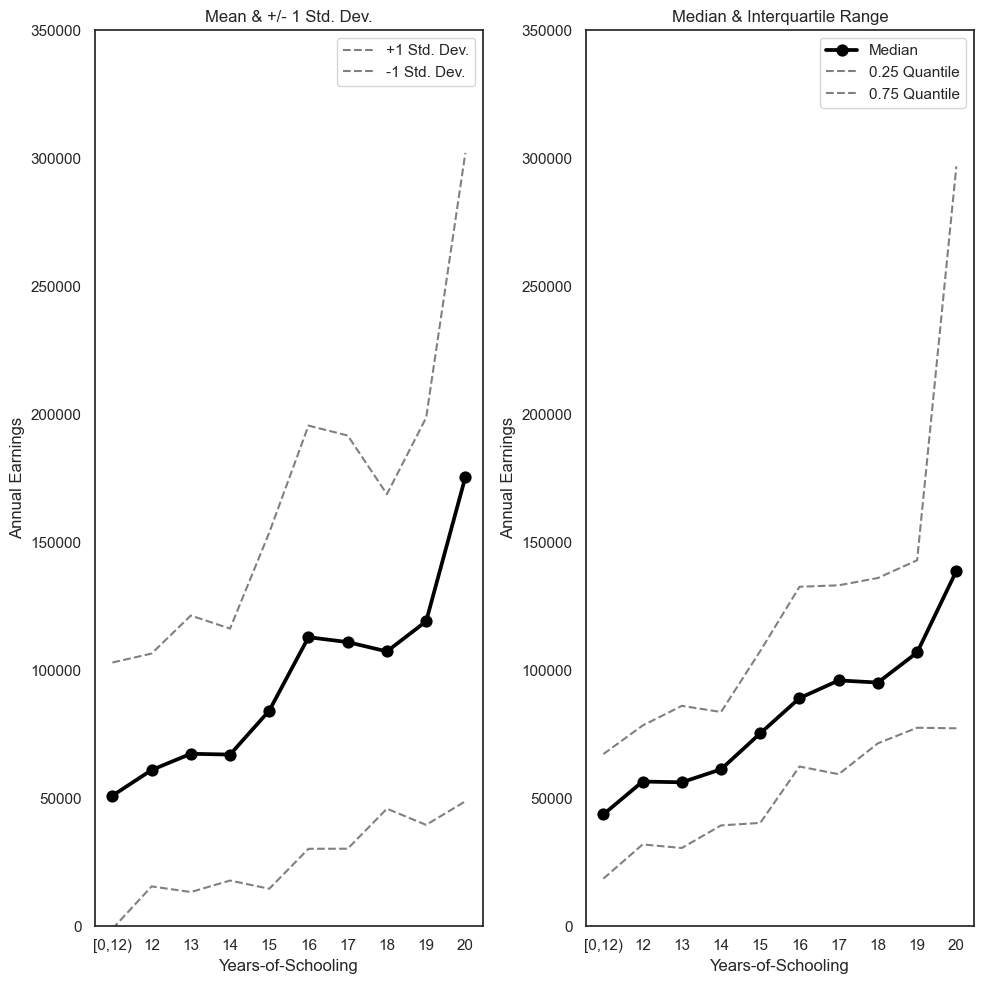

In [15]:
# Plot mean earnings +/- 1 std by schooling group
reg_fig = plt.figure(figsize=(10, 10))

# First subplot: Mean and +/- 1 Std. Dev.
ax1 = reg_fig.add_subplot(1, 2, 1)
sns.pointplot(x="Schooling", y="Mean", data=regframe, color="black", ax=ax1)
ax1.plot(regframe['Schooling'], regframe['Mean_plus_1Std'], color="gray", linestyle="--", label="+1 Std. Dev.")
ax1.plot(regframe['Schooling'], regframe['Mean_minus_1Std'], color="gray", linestyle="--", label="-1 Std. Dev.")
ax1.set_title('Mean & +/- 1 Std. Dev.')
ax1.set_xlabel('Years-of-Schooling')
ax1.set_ylabel('Annual Earnings')
ax1.set_ylim([0, 350000])
ax1.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])
ax1.legend()

# Second subplot: Median and Interquartile Range
ax2 = reg_fig.add_subplot(1, 2, 2)
sns.pointplot(x="Schooling", y="Median", data=regframe, color="black", ax=ax2, label="Median")
ax2.plot(regframe['Schooling'], regframe['0.25 Quantile'], color="gray", linestyle="--", label="0.25 Quantile")
ax2.plot(regframe['Schooling'], regframe['0.75 Quantile'], color="gray", linestyle="--", label="0.75 Quantile")
ax2.set_title('Median & Interquartile Range')
ax2.set_xlabel('Years-of-Schooling')
ax2.set_ylabel('Annual Earnings')
ax2.set_ylim([0, 350000])
ax2.set_yticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])
ax2.legend()

# Save and show the plots
plt.tight_layout()
plt.savefig(graphics + 'Fig_cef_earn_given_sch.png')
plt.show()

In [16]:
# This imports an attractive notebook style from Github
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen('http://bit.ly/1Bf5Hft')
HTML(html.read().decode('utf-8'))